Jupyter notebook 
-------

This notebook illustrates the codes used to generate single and accummulated AUC for selected proteins as shown in Fig. 1b of the paper **"Data independent acquisition mass spectrometry in severe Rheumatic Heart Disease (RHD) identifies a proteomic signature showing ongoing inflammation and effectively classifying RHD cases"**

Author: **Jing Yang**

Date: **17/11/2021**

Contact: Jing.Yang@manchester.ac.uk


In [1]:
library(caret)
library(data.table)
library(tidyverse)
library(Boruta)
library(DescTools)
library(broom)

Loading required package: ggplot2

Loading required package: lattice

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::lift()      masks caret::lift()
✖ purrr::transpose() masks data.table::transpose()


Attaching package: ‘DescTools’


The following object is masked from ‘package:data.table’:

    %like%


The following objects are masked from ‘package:caret’:

    MAE, RMSE




In [2]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.7 LTS

Matrix products: default
BLAS:   /usr/lib/openblas-base/libblas.so.3
LAPACK: /usr/lib/libopenblasp-r0.2.18.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] broom_0.7.9       DescTools_0.99.43 Boruta_7.0.0      forcats_0.5.1    
 [5] stringr_1.4.0     dplyr_1.0.7       purrr_0.3.4       readr_2.0.2      
 [9] tidyr_1.1.4       tibble_3.1.5      tidyverse_1.3.1   data.table_1.14.2
[13] caret_6.0-89      lattice_0.20-45   ggplot2_3.3.5    

loaded v

### Read log2 scaled protein expression data, log2 fold change data and the mapping between UniProtID and protein names

In [3]:
### data is log2 scaled protein expression data
### fold change is generated from the notebook "get_foldchange.ipynb"
data <- read.csv(file='RHD_data_filtered.csv', stringsAsFactors = FALSE)
foldchange_data <- read.csv('Protein_withfoldchange.csv', header=TRUE)
protein_withname <- read.table('protein_withname.txt', header=TRUE)

In [4]:
head(foldchange_data)

,UniProtID,ProteinName,mean_Case,mean_Control,log2foldchange,p_value,t_value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P05164,MPO,17.43545,15.98783,1.4476155,2.440581e-03,3.064512
2,P02741,CRP,13.93564,12.76735,1.1682886,4.488543e-08,5.591432
3,P0DJI8,SAA1,12.33971,11.19757,1.1421394,7.991483e-06,4.556095
4,Q15848,ADIPOQ,11.21368,10.07740,1.1362792,6.494611e-22,10.646823
5,P04406,GAPDH,13.44243,12.47953,0.9629039,1.315826e-02,2.507173
6,P01861,IGHG4,13.83671,12.97800,0.8587099,4.533116e-04,3.546973


In [5]:
head(data)

,StollerID,A5YKK6,B9A064,O00187,O00391,O00429,O00533,O14556,O14791,O14980,⋯,Q9UQ35,Q9Y2S2,Q9Y2Z0,Q9Y446,Q9Y490,Q9Y4L1,Q9Y5Y7,Q9Y6R7,Q9Y6U3,Group
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,RHD01_1,18.72726,13.32757,9.545403,10.93532,NA,9.693684,10.765847,13.54541,14.28571,⋯,NA,16.33353,17.04409,13.99638,18.55010,10.78719,11.558106,NA,16.02570,Case
2,RHD01_10,17.09342,11.99219,11.119640,11.36314,12.65523,NA,11.287226,13.51076,NA,⋯,NA,NA,15.68102,14.41961,18.27449,11.17612,NA,17.57590,15.99541,Control
3,RHD01_100,NA,16.99410,9.841260,12.05345,13.49063,10.120308,9.788836,13.07768,15.63010,⋯,NA,16.21441,14.98246,15.27436,18.64911,11.67593,9.798376,18.05495,15.21582,Control
4,RHD01_101,NA,11.05973,10.855083,11.52179,14.05859,10.599453,10.542719,13.98480,15.74108,⋯,10.031960,16.51174,NA,NA,19.14743,12.67218,10.626237,NA,16.07679,Control
5,RHD01_102,18.01907,14.42647,NA,12.03946,13.58525,10.212223,10.447536,14.15161,15.58056,⋯,9.875406,16.80517,NA,15.85524,18.39157,11.65981,11.531890,19.18588,16.05441,Control
6,RHD01_103,17.32733,14.57000,10.600376,12.43219,13.43931,10.531699,10.678076,13.50614,14.92608,⋯,10.815293,16.79194,NA,15.80052,19.43061,11.51000,11.223427,NA,16.29087,Control


In [6]:
data[is.na(data)] <- 0

### Read baseline data for all the samples

In [7]:

baseline_data <- fread('Demographic_info.csv')

In [8]:
head(baseline_data)

StollerID,Age,Gender,BMI,Group
<chr>,<int>,<chr>,<dbl>,<chr>
RHD01_1,17,Female,21.48438,Case
RHD01_10,26,Male,NA,Control
RHD01_100,34,Female,16.00366,Control
RHD01_101,46,Female,30.11600,Control
RHD01_102,28,Female,34.60208,Control
RHD01_103,45,Male,26.53376,Control


### Proteins selected from Boruta algorithm are imported directly

In [9]:
load(file='Boruta_results_2108.RData')
result_allsample <- attStats(Boruta.allsample) %>% filter(decision %in% 'Confirmed') %>% mutate(UniProtID=rownames(.)) %>% arrange(desc(medianImp))
proteins_confirmed <- result_allsample$UniProtID

### Start calculate ROC for each protein

In [10]:
ROC_single <- data.table()
coef_single <- data.table()
coef_single_oddsratio <- data.table()
ci_lower <- list()
ci_upper <- list()
pvalue_single <- list()

for (ii in 1:length(proteins_confirmed))
    {
    proteins_forlogistic <- proteins_confirmed[ii]
    tmp <- data %>% select(StollerID, any_of(proteins_forlogistic), Group)
    tmp[is.na(tmp)] <- 0
    joined_data <- inner_join(tmp, baseline_data) %>% select(Group, Age, BMI, Gender, any_of(proteins_forlogistic))
    joined_data$Group <- factor(joined_data$Group, levels=c('Case','Control'))
    levels(joined_data$Group) <- c(1,0)
    joined_data_clean <- joined_data[complete.cases(joined_data),] %>% mutate(BMIAge = BMI * Age)
    #joined_data1_clean$BMIAge <- joined_data1_clean$BMI * joined_data_clean$Age

    mf1 <- glm(Group~., data=joined_data_clean, family=binomial, na.action = na.pass)

    coef_single <- rbind(coef_single, (tidy(mf1) %>% filter(term %in% proteins_forlogistic)))
    #print(coef_single)
    tmp_oddsratio <- as.data.frame(exp(cbind(coef(mf1), confint(mf1)))) %>% filter(rownames(.) %in% proteins_forlogistic)
    coef_single_oddsratio <- rbind(coef_single_oddsratio, tmp_oddsratio)
    ROC_single <- rbind(ROC_single, Cstat(mf1)) 
    print(proteins_forlogistic)
    print(Cstat(mf1))
}

Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q15848"
[1] 0.8197523


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P10643"
[1] 0.8154505


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O00391"
[1] 0.7735135


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P35858"
[1] 0.798536


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P20742"
[1] 0.7942568


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P80108"
[1] 0.7990315


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P23142"
[1] 0.7922072


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P25311"
[1] 0.7942342


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P36955"
[1] 0.784527


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P06396"
[1] 0.7868243


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P00450"
[1] 0.7811261


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q99784"
[1] 0.7699099


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02743"
[1] 0.7951577


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02749"
[1] 0.7840766


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P19320"
[1] 0.772759


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P61626"
[1] 0.7709234


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O75636"
[1] 0.8106532


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P30041"
[1] 0.7696847


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P05546"
[1] 0.7872523


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P07333"
[1] 0.7610135


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P51884"
[1] 0.757455


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q06033"
[1] 0.7677252


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P07237"
[1] 0.7432432


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P05090"
[1] 0.7784685


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02766"
[1] 0.7836712


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P62701"
[1] 0.7470045


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02741"
[1] 0.7933333


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P61769"
[1] 0.7612613


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P11413"
[1] 0.7434685


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q9UK55"
[1] 0.7686261


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02790"
[1] 0.7933108


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P29622"
[1] 0.7707207


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q86VB7"
[1] 0.7531982


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O95445"
[1] 0.7512162


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P17948"
[1] 0.7431306


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q9Y6U3"
[1] 0.7996396


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P35442"
[1] 0.7596396


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O75369"
[1] 0.756036


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02750"
[1] 0.7675225


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O14791"
[1] 0.7881532


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P06276"
[1] 0.7891667


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P04424"
[1] 0.7428604


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P05186"
[1] 0.7570045


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02654"
[1] 0.7737613


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O43707"
[1] 0.7604279


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P27169"
[1] 0.7902928


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P32119"
[1] 0.7504279


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P19827"
[1] 0.7669595


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P03952"
[1] 0.7820946


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "O14980"
[1] 0.7526577


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q6UX04"
[1] 0.7525


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P02656"
[1] 0.7643468


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "Q9H4G4"
[1] 0.7431982


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P19823"
[1] 0.7595045


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P22307"
[1] 0.7522635


Joining, by = c("StollerID", "Group")

Waiting for profiling to be done...



[1] "P17936"
[1] 0.7629279


In [11]:
coef_single_oddsratio$UniProtID <- proteins_confirmed
coef_single_oddsratio$Pvalue <- coef_single$p.value

In [12]:
coef_single_oddsratio$AUC <- ROC_single$x

In [13]:
head(coef_single_oddsratio)

V1,2.5 %,97.5 %,UniProtID,Pvalue,AUC
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
0.8461151,0.8067519,0.8856642,Q15848,2.001505e-12,0.8197523
0.2944265,0.2027579,0.4154781,P10643,2.136884e-11,0.8154505
0.7877939,0.6794266,0.8925359,O00391,5.582735e-04,0.7735135
2.9622095,2.1008975,4.2843974,P35858,2.161213e-09,0.7985360
0.4435953,0.3333353,0.5796929,P20742,7.978237e-09,0.7942568
2.5051532,1.8687163,3.4329480,P80108,2.938326e-09,0.7990315


### Generate Table 2 illustated in the paper

In [14]:
names(coef_single_oddsratio)[1] <- c('OddsRatio')
ROC_single <- left_join(left_join(coef_single_oddsratio, foldchange_data %>% select(-c(p_value, t_value))), result_allsample %>% 
                        select(UniProtID, meanImp)) %>% select(UniProtID, ProteinName, mean_Case, mean_Control, log2foldchange, meanImp, 
                                                             OddsRatio, everything()) %>% mutate_if(is.numeric, format, digits=4)

Joining, by = "UniProtID"

Joining, by = "UniProtID"



In [15]:
ROC_single

UniProtID,ProteinName,mean_Case,mean_Control,log2foldchange,meanImp,OddsRatio,2.5 %,97.5 %,Pvalue,AUC
<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Q15848,ADIPOQ,11.21,10.08,1.1363,13.666,0.8461,0.8068,0.8857,2.002e-12,0.8198
P10643,C7,16.72,16.00,0.7202,11.759,0.2944,0.2028,0.4155,2.137e-11,0.8155
O00391,QSOX1,12.49,11.96,0.5213,9.947,0.7878,0.6794,0.8925,5.583e-04,0.7735
P35858,IGFALS,15.40,15.99,-0.5951,9.204,2.9622,2.1009,4.2844,2.161e-09,0.7985
P20742,PZP,16.64,15.79,0.8456,8.950,0.4436,0.3333,0.5797,7.978e-09,0.7943
P80108,GPLD1,12.63,13.30,-0.6684,8.455,2.5052,1.8687,3.4329,2.938e-09,0.7990
P23142,FBLN1,13.86,13.31,0.5494,7.487,0.5105,0.3736,0.6851,1.437e-05,0.7922
P25311,AZGP1,16.57,17.07,-0.4948,6.999,2.8800,2.0394,4.1554,5.299e-09,0.7942
P36955,SERPINF1,15.19,15.66,-0.4727,6.663,3.0565,2.0614,4.6352,6.074e-08,0.7845


In [16]:
write.table(file='ROC_for_single_protein.csv',ROC_single, quote=F, row.names=F, sep=',')

### Calculate accummulated ROC for selected proteins

In [17]:
ROC_accummulate <- data.table()

for (ii in 1:length(proteins_confirmed)){
    proteins_forlogistic <- proteins_confirmed[1:ii]
    tmp <- data %>% select(StollerID, any_of(proteins_forlogistic), Group)
    tmp[is.na(tmp)] <- 0
    joined_data <- inner_join(tmp, baseline_data) %>% select(Group, Age, BMI, Gender, any_of(proteins_forlogistic))
    joined_data$Group <- factor(joined_data$Group, levels=c('Case','Control'))
    levels(joined_data$Group) <- c(1,0)
    joined_data_clean <- joined_data[complete.cases(joined_data),] %>% mutate(BMIAge = BMI * Age)
    mf1 <- glm(Group~., data=joined_data_clean, family=binomial, na.action = na.pass)
    print(proteins_forlogistic)
    print(Cstat(mf1))
    ROC_accummulate <- rbind(ROC_accummulate, round(Cstat(mf1),3))
}

Joining, by = c("StollerID", "Group")



[1] "Q15848"
[1] 0.8197523


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643"
[1] 0.8357432


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391"
[1] 0.8354955


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391" "P35858"
[1] 0.8812838


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391" "P35858" "P20742"
[1] 0.8952252


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108"
[1] 0.9001802


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142"
[1] 0.9131532


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
[1] 0.9279054


Joining, by = c("StollerID", "Group")



[1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
[9] "P36955"
[1] 0.9304054


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396"
[1] 0.945


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450"
[1] 0.9472072


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784"
[1] 0.946982


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743"
[1] 0.9472297


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749"
[1] 0.9468694


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320"
[1] 0.947027


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[1] 0.947545


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636"
[1] 0.9477928


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041"
[1] 0.9490991


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546"
[1] 0.9493694


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333"
[1] 0.9499099


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884"
[1] 0.9512387


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033"
[1] 0.9514865


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237"
[1] 0.9518243


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[1] 0.9523874


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766"
[1] 0.9523874


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701"
[1] 0.952545


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741"
[1] 0.9525225


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769"
[1] 0.9532432


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413"
[1] 0.9533559


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55"
[1] 0.9533784


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790"
[1] 0.9541667


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[1] 0.9541667


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7"
[1] 0.9540315


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445"
[1] 0.9550901


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948"
[1] 0.955


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3"
[1] 0.9547973


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442"
[1] 0.9553604


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369"
[1] 0.955518


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750"
[1] 0.9553153


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[1] 0.9576126


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276"
[1] 0.959527


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424"
[1] 0.959527


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186"
[1] 0.9601577


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654"
[1] 0.9600901


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707"
[1] 0.9602252


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169"
[1] 0.9606982


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119"
[1] 0.9610135


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[1] 0.9622523


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952"
[1] 0.9628829


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980"
[1] 0.9633784


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980" "Q6UX04"
[1] 0.9635586


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980" "Q6UX04" "P02656"
[1] 0.9643694


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980" "Q6UX04" "P02656" "Q9H4G4"
[1] 0.9644144


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980" "Q6UX04" "P02656" "Q9H4G4" "P19823"
[1] 0.9679505


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980" "Q6UX04" "P02656" "Q9H4G4" "P19823" "P22307"
[1] 0.9683784


Joining, by = c("StollerID", "Group")



 [1] "Q15848" "P10643" "O00391" "P35858" "P20742" "P80108" "P23142" "P25311"
 [9] "P36955" "P06396" "P00450" "Q99784" "P02743" "P02749" "P19320" "P61626"
[17] "O75636" "P30041" "P05546" "P07333" "P51884" "Q06033" "P07237" "P05090"
[25] "P02766" "P62701" "P02741" "P61769" "P11413" "Q9UK55" "P02790" "P29622"
[33] "Q86VB7" "O95445" "P17948" "Q9Y6U3" "P35442" "O75369" "P02750" "O14791"
[41] "P06276" "P04424" "P05186" "P02654" "O43707" "P27169" "P32119" "P19827"
[49] "P03952" "O14980" "Q6UX04" "P02656" "Q9H4G4" "P19823" "P22307" "P17936"
[1] 0.9681081


In [18]:
ROC_accummulate$UniProtID <- proteins_confirmed
names(ROC_accummulate) <- c('AUC','UniProtID')

In [19]:
ROC_accummulate <- left_join(ROC_accummulate, protein_withname) %>% select(UniProtID, ProteinName, AUC)

Joining, by = "UniProtID"



In [20]:
head(ROC_accummulate)

UniProtID,ProteinName,AUC
<chr>,<fct>,<dbl>
Q15848,ADIPOQ,0.820
P10643,C7,0.836
O00391,QSOX1,0.835
P35858,IGFALS,0.881
P20742,PZP,0.895
P80108,GPLD1,0.900


In [21]:
ROC_accummulate$ProteinName <- factor(ROC_accummulate$ProteinName, levels=ROC_accummulate$ProteinName)

### Generate Fig 1b

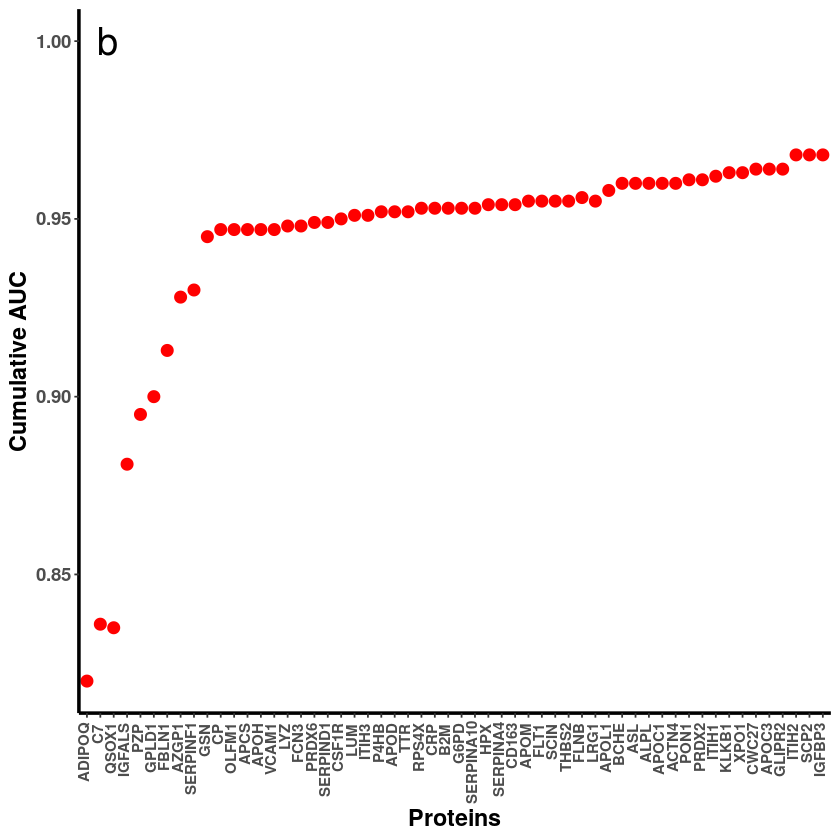

In [22]:
ggplot(ROC_accummulate, aes(x=ProteinName, y=AUC)) + geom_point(col='red', size=3) + 
annotate("text", x = 2.5, y = 1, label = "b", size=8) + 
xlab('Proteins') + ylab('Cumulative AUC') +  theme(panel.background=element_blank(),#panel.background=element_rect(fill='white',color='black',linetype=1), 
      #panel.grid.major=element_line(color='grey', size=0.1), 
     axis.line=element_line(size=1),text=element_text(size=14, face="bold"),
      axis.text.x=element_text(size=9, angle=90, face='bold', hjust=0.95, vjust=0.2), axis.title=element_text(size=14, face="bold"),
      strip.text.x=element_blank(),strip.text.y=element_blank(), strip.background=element_blank()) 